**This DCGAN is come from the PyTorch Tutorial.** Link: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
manualSeed = 999
print("Random Seed: ", manualSeed)
result = random.seed(manualSeed)
print("random.seed(manualSeed): ", result)
result = torch.manual_seed(manualSeed)
print("torch.manual_seed(manualSeed): ", result)

Random Seed:  999
random.seed(manualSeed):  None
torch.manual_seed(manualSeed):  <torch._C.Generator object at 0x7fb748f64490>


**Hyperparameter**

In [34]:
# Hyperparameter

# Root directory for dataset
dataroot = "/content/drive/MyDrive/celeba"
 
# Number of workers for dataloader
workers = 2
 
# Batch size during training
batch_size = 128  # this is the number used in the paper
 
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
 
# Number of channels in the training images. For color images this is 3 (RGB)
nc = 3
 
# Size of z latent vector (i.e. size of generator input)
nz = 100
 
# Size of feature maps in generator
ngf = 64
 
# Size of feature maps in discriminator
ndf = 64
 
# Number of training epochs
num_epochs = 500
 
# Learning rate for optimizers
lr = 0.0002
 
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5 # same as the paper
 
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

**Load Data**

In [5]:
# print(dataroot)
dataset = dset.ImageFolder(root=dataroot,
              transform=transforms.Compose([
                  transforms.Resize(image_size),
                  transforms.CenterCrop(image_size),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
              ]))


In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=True, num_workers=2)

In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu>0) else "cpu")
print(device)

cuda:0


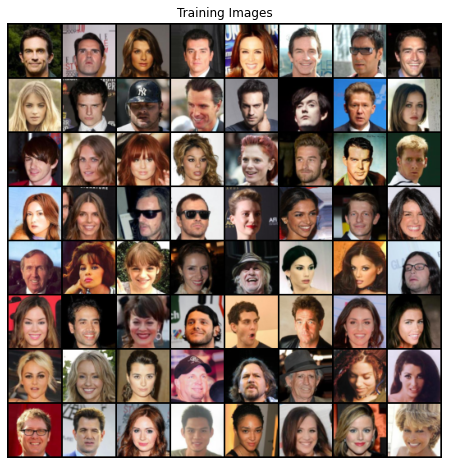

In [8]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

**Weight Initialization**

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Generator**

In [10]:
# class Generator(nn.Module):
#   def __init__(self, ngpu):
#     super(Generator,self).__init__()
#     self.ngpu = ngpu
#     self.conv1 = nn.Sequential(
#         # input is Z, going into a convolution
#         nn.ConvTranspose2d(in_channels=nz, out_channels=ngf*8, kernel_size=4, stride=1, padding=0, bias=False),
#         nn.BatchNorm2d(ngf*8),
#         nn.ReLU(True)
#     )

#     self.conv2 = nn.Sequential(
#         nn.ConvTranspose2d(in_channels=ngf*8, out_channels=ngf*4, kernel_size=4, stride=2, padding=1, bias=False),
#         nn.BatchNorm2d(ngf*4),
#         nn.ReLU(True),
#     )

#     self.conv3 = nn.Sequential(
#         nn.ConvTranspose2d(in_channels=ngf*4, out_channels=ngf*2, kernel_size=4, stride=2, padding=1, bias=False),
#         nn.BatchNorm2d(ngf*2),
#         nn.ReLU(True)
#     )


#     self.conv4 = nn.Sequential(
#         nn.ConvTranspose2d(in_channels=ngf*2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
#         nn.BatchNorm2d(ngf),
#         nn.ReLU(True),
#     )

#     self.out = nn.Sequential(
#         nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False),
#         nn.Tanh()
#     )


#     def forward(self, input):
#       input = self.conv1(input)
#       input = self.conv2(input)
#       input = self.conv3(input)
#       input = self.conv4(input)
#       out = self.out(input)
#       return out

In [11]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [12]:
netG = Generator(ngpu).to(device)

In [13]:
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

In [14]:
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

**Discriminator**

In [15]:
# class Discriminator(nn.Module):
#   def __init__(self, ngpu):
#     super(Discriminator,self).__init__()
#     self.ngpu = ngpu
#     self.conv1 = nn.Sequential(
#         nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False),
#         nn.LeakyReLU(0.2, inplace=True)
#     )

#     self.conv2 = nn.Sequential(
#         nn.Conv2d(in_channels=nc, out_channels=ndf*2, kernel_size=4, stride=2, padding=1, bias=False),
#         nn.BatchNorm2d(ndf*2),
#         nn.LeakyReLU(0.2, inplace=True)
#     )

#     self.conv3 = nn.Sequential(
#         nn.Conv2d(in_channels=nc*2, out_channels=ndf*4, kernel_size=4, stride=2, padding=1, bias=False),
#         nn.BatchNorm2d(ndf*4),
#         nn.LeakyReLU(0.2, inplace=True)
#     )

#     self.conv4 = nn.Sequential(
#         nn.Conv2d(in_channels=nc*4, out_channels=ndf*8, kernel_size=4, stride=2, padding=1, bias=False),
#         nn.BatchNorm2d(ndf*8),
#         nn.LeakyReLU(0.2, inplace=True)
#     )

#     self.out = nn.Sequential(
#         nn.Conv2d(in_channels=nc*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
#         nn.Sigmoid()
#     )

#     def forward(self, input):
#       input = self.conv1(input)
#       input = self.conv2(input)
#       input = self.conv3(input)
#       input = self.conv4(input)
#       out = self.out(input)
#       return out

In [16]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [17]:
netD = Discriminator(ngpu).to(device)

In [18]:
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

In [19]:
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

**Loss Function**

In [20]:
loss_func = nn.BCELoss()

# Batch of latent vectors used to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

**Labels**

In [21]:
real_label = 1
fake_label = 0

**Optimizers**

In [22]:
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1,0.999))

**Training**

In [23]:
img_list = []
G_losses = []
D_losses = []
iters = 0

In [36]:
print("Start Training")
for epoch in range(num_epochs):
  for i, data in enumerate(dataloader, 0): # i = 0, 1, 2 ...; data: tensor
    ###############################
    # D network: maximize log(D(x))+log(1-D(G(z)))
    ###############################

    netD.zero_grad()

    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0) # 128 72
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # print(label)
    # Forward pass through D network
    output = netD(real_cpu).view(-1)
    # print(output)
    # error on real batch
    errD_real = loss_func(output,label)
    # print(errD_real)
    # Gradient for D
    errD_real.backward()
    D_x = output.mean().item()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size,nz,1,1,device=device)
    # print(noise)
    fake = netG(noise)
    label.fill_(fake_label)

    # Classify all fake batch with D
    output = netD(fake.detach()).view(-1)
    # D's loss on fake batch
    errD_fake = loss_func(output,label)
    # gradient for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # add gradient from all-real and all-fake batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ###################
    # G network: maximize log(D(G(z)))
    ###################
    netG.zero_grad()
    label.fill_(real_label)

    output = netD(fake).view(-1)

    errG = loss_func(output,label)

    errG.backward()
    D_G_z2 = output.mean().item()

    optimizerG.step()

    # Output training stats
    if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(dataloader),
                  errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    iters += 1


Start Training
[0/500][0/2]	Loss_D: 0.0321	Loss_G: 13.8151	D(x): 0.9702	D(G(z)): 0.0000 / 0.0000
[1/500][0/2]	Loss_D: 0.8448	Loss_G: 30.5341	D(x): 0.9913	D(G(z)): 0.4831 / 0.0000
[2/500][0/2]	Loss_D: 0.1945	Loss_G: 37.4148	D(x): 0.9099	D(G(z)): 0.0000 / 0.0000
[3/500][0/2]	Loss_D: 0.0060	Loss_G: 38.6419	D(x): 0.9945	D(G(z)): 0.0000 / 0.0000
[4/500][0/2]	Loss_D: 0.0016	Loss_G: 38.7567	D(x): 0.9984	D(G(z)): 0.0000 / 0.0000
[5/500][0/2]	Loss_D: 0.0007	Loss_G: 38.8033	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[6/500][0/2]	Loss_D: 0.0002	Loss_G: 38.7624	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[7/500][0/2]	Loss_D: 0.0007	Loss_G: 38.8620	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[8/500][0/2]	Loss_D: 0.0004	Loss_G: 38.8001	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[9/500][0/2]	Loss_D: 0.0003	Loss_G: 38.7088	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[10/500][0/2]	Loss_D: 0.0004	Loss_G: 38.6631	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[11/500][0/2]	Loss_D: 0.0003	Loss_G: 38.7200	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000

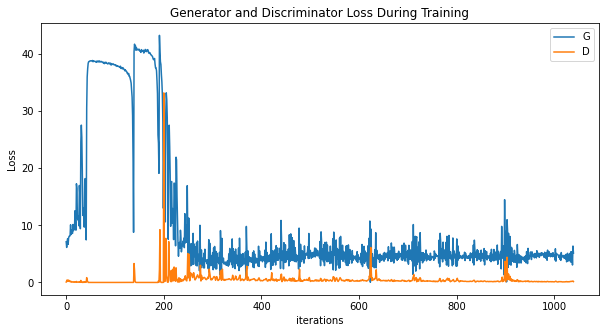

In [37]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

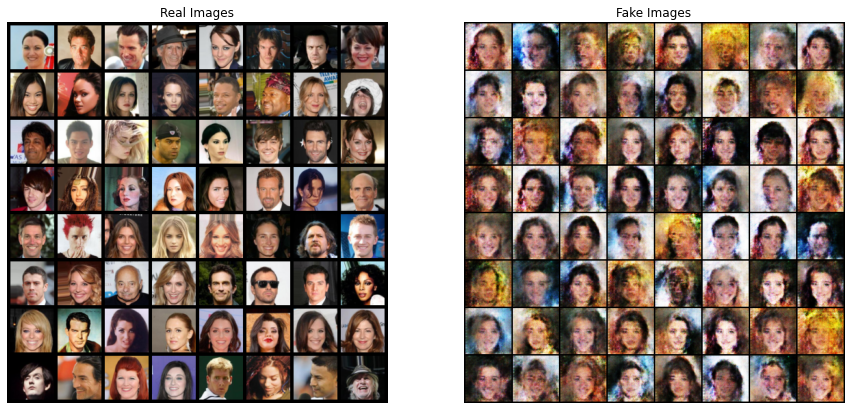

In [38]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()